In [15]:
import torch.nn as nn

class Policy(nn.Module):
  def __init__(self,input_shape):
    super().__init__()
    print("input_shape",input_shape)
    self.model = nn.Sequential(
        nn.Linear(input_shape[0],32),
        nn.ReLU(),
        nn.Linear(32,32),
        nn.ReLU(),
        nn.Linear(32,32),
        nn.ReLU(),
        nn.Linear(32,32),
        nn.ReLU(),
        nn.Linear(32,32),
    )
    self.mean = nn.Sequential(nn.Linear(32, input_shape[0]),
                                  nn.Tanh())                    # tanh squashed output to the range of -1..1
    self.variance =nn.Sequential(nn.Linear(32, input_shape[0]),
                                     nn.Softplus())
  def forward(self,x):
    x = self.model(x)
    return self.mean(x), self.variance(x)

In [19]:
from pymoo.core.algorithm import Algorithm
from pymoo.operators.sampling.rnd import FloatRandomSampling
from torch.distributions import Normal, Uniform
from pymoo.core.initialization import Initialization
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.core.population import Population
from pymoo.operators.repair.bounds_repair import is_out_of_bounds_by_problem
from pymoo.core.repair import NoRepair
from torch import optim
import torch
import numpy as np
from pymoo.util.optimum import filter_optimum

class MonteCarloGradientPolicyAlgorithm(Algorithm):
    def __init__(self,
                 gamma=0.99,
                 alpha=0.01,
                 num_rounds=200,
                 sample_size=500,
                 sampling=FloatRandomSampling(),
                 repair=NoRepair(),
                 **kwargs):
        
        """
        Parameters
        ----------
        env : 
            The environment to be used in the algorithm.
        policy : {Policy}
            The policy to be used in the algorithm.
        gamma : float, optional
            The discount factor used in the algorithm. The default is 0.99.
        alpha : float, optional
            The learning rate used in the algorithm. The default is 0.01.
        num_episodes : int, optional
            The number of episodes to be run in the algorithm. The default is 100.
        sample_size : int, optional
            The number of samples to be generated from the problems and used in the acquisition function. 
            The default is 10.
        sampling : {Sampling}, optional
            The sampling method used to generate the initial samples. The default is FloatRandomSampling().
        """
         
        super().__init__(**kwargs)

        self.gamma = gamma
        self.alpha = alpha
        self.num_rounds = num_rounds
        self.sample_size = sample_size
        self.sampling = sampling
        self.repair = repair
        
        self.initialization = Initialization(sampling)
        self.survival = RankAndCrowdingSurvival()
        self.crossover = SimulatedBinaryCrossover(n_offsprings=1)
        self.is_constraint_model = False
        self.optimizer = None
        self.data_set_X = None
        self.model = None
        self.states = []
        self.actions = []
        self.probs = []
        self.rewards = []
        self.steps_taken = []
        

    def _setup(self, problem, **kwargs):
        if self.problem.n_ieq_constr + self.problem.n_eq_constr > 0:
            self.is_constraint_model = True
        self.model = Policy(np.array([self.problem.n_var]))
        self.optimizer = optim.Adam(self.model.parameters(), lr = 5e-3)
        self.mean = self.problem.xl + (self.problem.xu - self.problem.xl)/2
        self.std = np.sqrt(((self.problem.xu - self.problem.xl)**2)/12)
        
    def _initialize_infill(self):
        return self.initialization.do(self.problem, 1, algorithm=self)

    def _initialize_advance(self, infills=None, **kwargs):
        self.data_set_X = self.pop.get("X")
        #super()._initialize_advance(infills=infills, **kwargs)

    def _infill(self):
        print(self.pop.size)
        
        state = self.get_starting_point()
        normalized_state = self.state_normalization(state)
        print("normalized_state1",normalized_state)
        termination_rounds = self.num_rounds 
        steps = 0
        ep_rewards = 0
        batch_rewards = []
        log_probs = []

        while steps < termination_rounds:
            #print("self.opt.get(F)",self.opt.get("F"))
           # print("self.problem.evaluate(np.array(state))[0]",self.problem.evaluate(np.array(state))[0])
            a, log_p = self.action(torch.Tensor(normalized_state).unsqueeze(0))
            log_probs.append(log_p)
            new_state, reward = self.step(a,normalized_state)
            batch_rewards.append(reward)
            ep_rewards += reward
            steps +=1
            #print("state:", state)
            state = new_state
            #if steps + 1 == termination_rounds  and np.any(batch_rewards[-100:]) and termination_rounds  < 15000:
                #print("steps:", steps)
                #print("batch_rewards[-100:]", batch_rewards[-100:])
                #termination_rounds  += 100
        print("normalized_state2",normalized_state)
        self.data_set_X = np.vstack((self.data_set_X, normalized_state))
        print("self.data_set_X",self.data_set_X)
        off = Population.new(X=self.data_set_X, F = self.problem.evaluate(self.data_set_X, return_values_of=["F"]))
        self.pop = off
        self.rewards.append(ep_rewards)
        self.steps_taken.append(steps)
        print("Episode: {} --- Rewards: {} --- Steps: {}".format(self.n_iter, ep_rewards, steps))
        self.update_policy(self.n_iter, self.optimizer, batch_rewards, log_probs)

        
        return self.pop
        
    def _advance(self, infills=None, **kwargs):
        return super()._advance(infills=infills, **kwargs)
    
    
    def _finalize(self):
        return super()._finalize()
    
    def action(self, state):
        # simple pytorch aproach for action-selection and log-prob calc 
        #action_parameters = model(s)
        mu,variance = self.model(state)
        sigma = torch.sqrt(variance)
        #print("action_parameters:", action_parameters)
        #m = Categorical(prob)
        #print("action_parameters[:, :1]:", action_parameters[:, :1])
        #print("action_parameters[:, 1:]:", action_parameters[:, 1:])
        #mu, sigma = action_parameters[:, :1], torch.exp(action_parameters[:, 1:])
        #mu, c = action_parameters[:, :1], 1
        
        #print("mu:", mu)
        #print("sigma:", sigma)
        m = Normal(mu, sigma+0.00001)
        #print("m:", m)
        a = m.sample()
        #print("a:", a.tolist())
        # log p(a∣π(s))
        log_p = m.log_prob(a)
        #print("log_p:", log_p)
        #print(a.item(), log_p)
        return a.tolist(), log_p
    
    def get_rewards(self, current_state, new_state):
        eucli_dist = self.problem.evaluate(current_state, return_values_of=["F"]) - self.problem.evaluate(new_state, return_values_of=["F"])
        #print("self.problem.evaluate(new_state)[0]",self.problem.evaluate(new_state)[0])
        #print("self.problem.evaluate(current_state)[0]",self.problem.evaluate(current_state)[0])
        Y_cv = 0
        if self.is_constraint_model : 
            Y_cv = self.problem.evaluate(new_state, return_values_of=["CV"])    
        if Y_cv > 0 or len(is_out_of_bounds_by_problem(self.problem, [new_state])) > 0:
            return -3*eucli_dist# + self.penalty_function(new_state) + Y_cv**2)
        elif eucli_dist < 0:
            return -3*eucli_dist
        elif eucli_dist > 0:
            return 3*eucli_dist
        elif eucli_dist == 0:
            return -1
        else:
            return 1*eucli_dist
    
    def penalty_function(self, state):
        return  np.sum(np.maximum(0, state - self.problem.xu)**2) + np.sum(np.maximum(0, self.problem.xl - state)**2)
    
    def get_starting_point(self):
        if self.pop.size <= 2 or np.random.random_sample() > 0.5:
            return self.initialization.do(self.problem, 1, algorithm=self).get("X")[0]
        else:
            new_parents = self.survival.do(self.problem, self.pop, n_survive=2)
            new_state = self.crossover.do(self.problem, [new_parents]).get("X")[0]
            return new_state
    def state_normalization(self, state):
        return (state - self.mean)/self.std



    def step(self, action, state):
        current_X = state
        X_new = current_X[0] + action[0]
        reward = 0
        #print("current_X:", current_X)
        #print("action:", action)
        while len(is_out_of_bounds_by_problem(self.problem, [X_new])) > 0:           
            X_new = self.sampling.do(self.problem, 1, algorithm=self).get("X")[0]
        reward = self.get_rewards(current_X, X_new)
        
        
        #if self.is_constraint_model or self.problem.n_eq_constr > 0:
        #    Y_new = evlaution_of_new_points[0]
        #    Constraint_new = evlaution_of_new_points[1]
        #else:
        
        new_state = np.array(X_new)
        #print("rewards",reward)
        return new_state, reward
    
    def update_policy(self, ep, optimizer,batch_rewards,log_probs):
        R = 0
        policy_loss = []
        rewards = []
        #calc discounted Rewards
        for r in batch_rewards[::-1]: # reverses the list of rewards 
            R = r + self.gamma * R
            rewards.insert(0, R) # inserts the current reward to first position
        
        
        rewards = torch.tensor(rewards)
        # standardization to get data of zero mean and varianz 1, stabilizes learning 
        #-- attention scaling rewards looses information of special events with higher rewards - addapting on different environments  
        rewards = (rewards - rewards.mean()) / (rewards.std() + ep)
        for log_prob, reward in zip(log_probs, rewards):
            policy_loss.append(self.alpha*(-log_prob * reward)) #baseline+
        
        optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        print(" policy_loss", policy_loss)
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(),1)
        optimizer.step()
        """G = 0
        for t in reversed(range(len(states))):
            G = self.gamma * G + rewards[t]
            state = states[t]
            action = actions[t]
            grad_log_prob = self.policy.grad_log_prob(state, action)
            self.policy.theta += self.alpha * G * grad_log_prob"""

    """def run_episode(self):
        states = []
        actions = []
        rewards = []
        state = self.env.reset()
        done = False
        while not done:
            action = self.policy.sample_action(state)
            next_state, reward, done, _ = self.env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
        return states, actions, rewards"""
    

input_shape [20]
1
normalized_state1 [ 0.01817299 -1.50589172 -0.24899156 -1.39765791 -1.29155574  0.33513558
 -0.94912227 -1.36158009 -0.96888772 -0.52021701 -0.11158743 -1.03319177
  0.48638316 -0.05864781  0.01814053 -0.39181535  1.01718998  0.27714261
 -1.16983197  0.69542653]
normalized_state2 [ 0.01817299 -1.50589172 -0.24899156 -1.39765791 -1.29155574  0.33513558
 -0.94912227 -1.36158009 -0.96888772 -0.52021701 -0.11158743 -1.03319177
  0.48638316 -0.05864781  0.01814053 -0.39181535  1.01718998  0.27714261
 -1.16983197  0.69542653]
self.data_set_X [[-4.19463809e+00 -3.10688985e+01  3.25468015e+00 -4.23871168e+00
  -5.21877572e+00 -1.11191772e+01 -1.93561471e+01  7.81654205e+00
  -1.31298313e+01 -1.52812077e+01  7.93862686e+00  1.90985629e+00
  -2.39481687e+01  8.89855755e-01 -2.06805490e+01  1.86997242e+01
   2.31981248e+01 -3.77694625e-01  2.27122535e+01 -2.75483540e+01]
 [ 1.81729893e-02 -1.50589172e+00 -2.48991561e-01 -1.39765791e+00
  -1.29155574e+00  3.35135581e-01 -9.49122

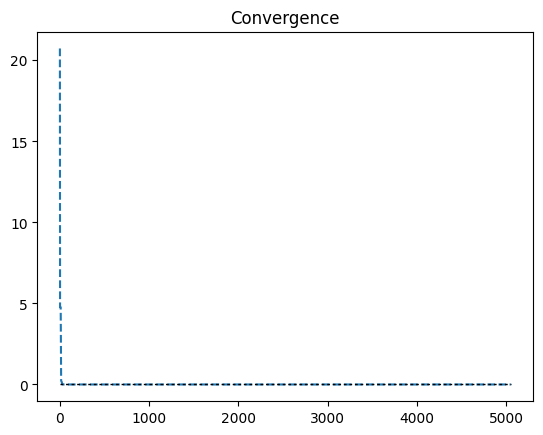

In [25]:
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
import matplotlib.pyplot as plt
import numpy as np
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination import get_termination
from random import randint
from pymoo.constraints.as_obj import ConstraintsAsObjective
from pymoo.termination.ftol import SingleObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.termination.default import DefaultMultiObjectiveTermination
import random

torch.manual_seed (2)

problem = get_problem("ackley", n_var=20, a=20, b=1/5, c=2 * np.pi)
problem1 = get_problem("Rastrigin", n_var=20)
problem2 = get_problem("Rosenbrock", n_var=20)
problem3 = get_problem("g1")
algorithm3 = MonteCarloGradientPolicyAlgorithm()
res = minimize( problem,
                algorithm3,
                save_history=True,
                termination=('n_iter', 100),
                seed = 2,
                return_least_infeasible=True,
                verbose=True)

pf = problem2.pareto_front()
print("PF",pf[0])
ind = GD(pf)
print("GD", ind(res.F))
ind2 = IGD(pf)
print("IGD", ind2(res.F))


n_evals = np.array([e.evaluator.n_eval for e in res.history])

opt = np.array([e.opt[0].F for e in res.history])
print("final result X:",res.X)
print("final result CV:",res.CV)
print(opt)
plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.plot(n_evals, np.repeat(pf[0],len(n_evals)), 'k-', lw=1,dashes=[2, 2])
#plt.yscale("log")
plt.show()

In [24]:
problem3.evaluate(res.X, return_values_of=["G"])


array([ -8.93230112,  -6.48061032,  -8.95243133, -15.55074813,
        -5.8520098 , -15.57087834,  -6.89049409,  -3.46410162,
        -3.44652269])

In [ ]:
np.array([1])